#### Data loading & preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
titanic_df = pd.read_csv("C:/Users/gmlkd/FastCampus/딥러닝_Advanced/실습 파일/1. Tensorflow (Problem)/titanic.csv")
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
del titanic_df['Cabin'] # 너무 많은 결측치가 존재
del titanic_df['PassengerId'] # Passenger 번호는 큰 의미를 갖고있지 않은 일련번호
del titanic_df['Ticket'] # ticket 번호에서 패턴이 확인되지 않음


titanic_df['Title'] = titanic_df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
del titanic_df['Name'] # 호칭만 남김

rare_title = []
for title in set(titanic_df['Title']):
    if list(titanic_df['Title']).count(title) < 10:
        rare_title.append(title)

titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss') # Mademoiselle
titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss') 
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs') # Madame
titanic_df['Title'] = titanic_df['Title'].replace(rare_title, 'Rare')

title_mapping = {"Master":1, "Miss":2, "Mr":3, "Mrs":4, "Rare":5 }
titanic_df['Title'] = titanic_df['Title'].map(title_mapping)
titanic_df['Title'] = titanic_df['Title'].fillna(0)
titanic_df['Title'].astype(int)


sex_mapping = {"male": 0 , "female":1} 
titanic_df['Sex'] = titanic_df['Sex'].map(sex_mapping)


titanic_df['Embarked'] = titanic_df['Embarked'].fillna('S')
mapping_data ={"S":0, "Q":1, "C":2}
titanic_df["Embarked"] = titanic_df["Embarked"].map(mapping_data)


titanic_df.loc[ titanic_df['Fare'] <= 102, 'Fare'] = 0
titanic_df.loc[(titanic_df['Fare'] > 102) & (titanic_df['Fare'] <= 204), 'Fare'] = 1
titanic_df.loc[(titanic_df['Fare'] > 204) & (titanic_df['Fare'] <= 307), 'Fare'] = 2
titanic_df.loc[ titanic_df['Fare'] > 307, 'Fare'] = 4


titanic_df["FamilySize"] = titanic_df["SibSp"] + titanic_df["Parch"] +1
del titanic_df['SibSp']
del titanic_df['Parch']

titanic_df['isAlone'] = 0
titanic_df.loc[titanic_df['FamilySize'] == 1, 'isAlone'] = 1

family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
titanic_df['FamilySize'] = titanic_df['FamilySize'].map(family_mapping)


titanic_df["Age"].fillna(titanic_df.groupby("Title")["Age"].transform("median"), inplace=True)

titanic_df.loc[ titanic_df['Age'] <= 16, 'Age'] = 0
titanic_df.loc[(titanic_df['Age'] > 16) & (titanic_df['Age'] <= 32), 'Age'] = 1
titanic_df.loc[(titanic_df['Age'] > 32) & (titanic_df['Age'] <= 48), 'Age'] = 2
titanic_df.loc[(titanic_df['Age'] > 48) & (titanic_df['Age'] <= 64), 'Age'] = 3
titanic_df.loc[ titanic_df['Age'] > 64, 'Age'] = 4

titanic_df.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,isAlone
0,0,3,0,1.0,0.0,0,3,0.4,0
1,1,1,1,2.0,0.0,2,4,0.4,0
2,1,3,1,1.0,0.0,0,2,0.0,1


#### Devide dataframe into X & Y -> Train X / Test X / Train Y / Test Y

In [5]:
titanic_target = titanic_df[['Survived']].copy()
titanic_data = titanic_df.copy()

del titanic_data['Survived']

In [6]:
from sklearn import model_selection

In [8]:
train_data, test_data, train_label, test_label = model_selection.train_test_split(titanic_data, titanic_target,
                                                                                 test_size=0.3,
                                                                                 random_state=0)
print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(623, 8)
(268, 8)
(623, 1)
(268, 1)


#### Change normal labels to one-hot labels

In [9]:
from tensorflow.keras import utils

train_label = utils.to_categorical(train_label) # 0 or 1 -> one-hot vector
test_label = utils.to_categorical(test_label) # 0 or 1 -> one-hot vector

print(train_label.shape) # 모양을 영어로?
print(test_label.shape) # 모양을 영어로?

# from sklearn import preprocessing
# enc = preprocessing.OneHotEncoder(categories='auto') # Apply 'One-hot encoding' on labels (Single integer to One-hot vector)
# train_label = enc.fit_transform(train_label).toarray()
# test_label = enc.fit_transform(test_label).toarray()

(623, 2)
(268, 2)


In [10]:
train_label

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

#### Build & Train the model 

In [11]:
import tensorflow as tf

# tf.keras 에 필요한 함수들이 모여있습니다.
from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

In [12]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

In [13]:
model = models.Sequential() # Build up the "Sequence" of layers (Linear stack of layers)

# Dense-layer (with he-initialization)
model.add(layers.Dense(input_dim=8, units=256, activation=None, kernel_initializer=initializers.he_uniform())) # he-uniform initialization
# model.add(layers.BatchNormalization()) # Use this line as if needed
model.add(layers.Activation('elu')) # elu or relu (or layers.ELU / layers.LeakyReLU)

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 
model.add(layers.Dropout(rate=0.5)) # Dropout-layer

model.add(layers.Dense(units=2, activation='softmax')) # Apply softmax function on model's output

In [14]:
# "Compile" the model description (Configures the model for training)

model.compile(optimizer=optimizers.Adam(), # Please try the Adam-optimizer
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy]) # Precision / Recall / F1-Score 적용하기 @ https://j.mp/3cf3lbi

In [15]:
# "Fit" the model on training data

history = model.fit(train_data, train_label, batch_size=100, epochs=20, validation_split=0.3) 

Epoch 1/20
5/5 [==============================] - 1s 36ms/step - loss: 5.1694 - categorical_accuracy: 0.6009 - val_loss: 1.9506 - val_categorical_accuracy: 0.4652
Epoch 2/20
5/5 [==============================] - 0s 10ms/step - loss: 1.5288 - categorical_accuracy: 0.6468 - val_loss: 1.5598 - val_categorical_accuracy: 0.6096
Epoch 3/20
5/5 [==============================] - 0s 11ms/step - loss: 1.1262 - categorical_accuracy: 0.6881 - val_loss: 0.5304 - val_categorical_accuracy: 0.7914
Epoch 4/20
5/5 [==============================] - 0s 11ms/step - loss: 0.8160 - categorical_accuracy: 0.7110 - val_loss: 0.5644 - val_categorical_accuracy: 0.7701
Epoch 5/20
5/5 [==============================] - 0s 15ms/step - loss: 0.8748 - categorical_accuracy: 0.6858 - val_loss: 0.4959 - val_categorical_accuracy: 0.8075
Epoch 6/20
5/5 [==============================] - 0s 9ms/step - loss: 0.6687 - categorical_accuracy: 0.7913 - val_loss: 0.4469 - val_categorical_accuracy: 0.8128
Epoch 7/20
5/5 [=======

In [16]:
# "Evaluate" the model on test data

result = model.evaluate(test_data, test_label)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

9/9 [==============================] - 0s 14ms/step - loss: 0.5177 - categorical_accuracy: 0.8246
loss (cross-entropy) : 0.5177280902862549
test accuracy : 0.8246268630027771


In [17]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

In [19]:
# y 좌표
print(history.history['categorical_accuracy'])

[0.6009174585342407, 0.646789014339447, 0.6880733966827393, 0.71100914478302, 0.6857798099517822, 0.7912843823432922, 0.7637614607810974, 0.7981651425361633, 0.8027523159980774, 0.78899085521698, 0.8119266033172607, 0.7729358077049255, 0.7798165082931519, 0.7821100950241089, 0.8073394298553467, 0.78899085521698, 0.8348624110221863, 0.7912843823432922, 0.7935779690742493, 0.7981651425361633]


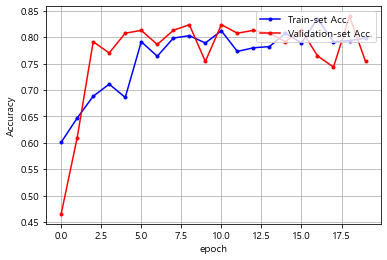

In [21]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

In [22]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

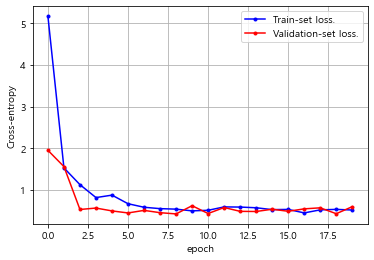

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

In [24]:
# 'Predict' on test data
## 마지막 output layer가 출력
model.predict(test_data)

array([[9.16805923e-01, 8.31941143e-02],
       [9.60529566e-01, 3.94704193e-02],
       [9.98613000e-01, 1.38694455e-03],
       [8.43006372e-03, 9.91569877e-01],
       [4.78321105e-01, 5.21678865e-01],
       [9.33115125e-01, 6.68848082e-02],
       [2.71467436e-02, 9.72853243e-01],
       [1.17731877e-02, 9.88226831e-01],
       [6.26937032e-01, 3.73062968e-01],
       [4.87645149e-01, 5.12354851e-01],
       [9.90051568e-01, 9.94838774e-03],
       [3.76821101e-01, 6.23178899e-01],
       [9.50220883e-01, 4.97790873e-02],
       [1.05506681e-01, 8.94493282e-01],
       [4.30528336e-04, 9.99569476e-01],
       [4.34128702e-01, 5.65871298e-01],
       [9.60529566e-01, 3.94704193e-02],
       [9.89697397e-01, 1.03025651e-02],
       [9.87740576e-01, 1.22594740e-02],
       [2.91376561e-02, 9.70862329e-01],
       [9.60689843e-01, 3.93101461e-02],
       [1.34920562e-02, 9.86508012e-01],
       [9.50220883e-01, 4.97790873e-02],
       [9.33115125e-01, 6.68848082e-02],
       [8.003537

In [25]:
np.argmax(model.predict(test_data), axis=1)

array([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [26]:
# Data 한건만 처리할 때

sample_data = np.array([[3, 0, 0.0, 0.0, 1, 1, 2.0, 0]])

In [27]:
model.predict(sample_data)

array([[0.9986117 , 0.00138824]], dtype=float32)

In [28]:
np.argmax(model.predict(sample_data), axis=1)

array([0], dtype=int64)